In [6]:
import sys, os

# Prepend the project root so 'models' and 'losses' are importable
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [7]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

# your project modules
from models.dml_model import OptionMLP
from losses.differential_loss import differential_loss

# ensure plots appear inline
%matplotlib inline

In [8]:
# 2.1 Load validation DataFrame
df_val = pd.read_csv("../data/val.csv")  # adjust path if needed

# features & true labels
X_val = torch.tensor(
    df_val[['S', 'K', 'T', 'r', 'sigma']].values, 
    dtype=torch.float32
)
y_price = torch.tensor(df_val['price'].values, dtype=torch.float32)
y_delta = torch.tensor(df_val['delta'].values, dtype=torch.float32)
y_vega  = torch.tensor(df_val['vega'].values,  dtype=torch.float32)

# 2.2 Instantiate & load your best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OptionMLP().to(device)
model.load_state_dict(torch.load("../dml_pricer_best.pth", map_location=device))
model.eval()


OptionMLP(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): SiLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): SiLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [9]:
# move to device and enable grad for X_val
X = X_val.to(device).clone().detach().requires_grad_(True)

# 3.1 Predicted prices
pred_price = model(X)              # shape (N,)
pred_price_np = pred_price.cpu().detach().numpy()

# 3.2 Predicted Greeks via autograd
grad_outputs = torch.ones_like(pred_price)
grads = torch.autograd.grad(
    outputs=pred_price,
    inputs=X,
    grad_outputs=grad_outputs,
    create_graph=False
)[0]                                # shape (N,5)

pred_delta = grads[:, 0].cpu().detach().numpy()
pred_vega  = grads[:, 4].cpu().detach().numpy()


In [15]:
# 4. 📊 Build an Error DataFrame (including original features)
df_err = df_val[['S', 'K', 'T', 'r', 'sigma']].copy()   # bring in features
# now add true vs predicted and error columns
df_err['true_price']  = df_val['price']
df_err['pred_price']  = pred_price_np
df_err['price_err']   = np.abs(df_err['pred_price'] - df_err['true_price'])

df_err['true_delta']  = df_val['delta']
df_err['pred_delta']  = pred_delta
df_err['delta_err']   = np.abs(df_err['pred_delta'] - df_err['true_delta'])

df_err['true_vega']   = df_val['vega']
df_err['pred_vega']   = pred_vega
df_err['vega_err']    = np.abs(df_err['pred_vega'] - df_err['true_vega'])

df_err.head()


,S,K,T,r,sigma,true_price,pred_price,price_err,true_delta,pred_delta,delta_err,true_vega,pred_vega,vega_err
0,110.484566,69.633804,1.729691,0.011214,0.225054,42.746924,45.383736,2.636811,0.961898,0.968002,0.006104,12.035697,11.338950,0.696747
1,100.264933,108.867126,1.221711,0.035145,0.462261,18.669993,19.886059,1.216065,0.570799,0.606822,0.036023,43.514277,43.073017,0.441260
2,121.470949,61.947577,1.125451,0.022903,0.360711,61.530530,62.699383,1.168853,0.978226,0.968849,0.009376,6.704925,7.920578,1.215652
3,57.273626,130.461170,1.662188,0.023679,0.452468,1.989619,2.706582,0.716963,0.146382,0.223834,0.077452,16.937564,16.082670,0.854893
4,88.767160,111.991824,0.198525,0.019684,0.247564,0.076687,1.378581,1.301894,0.021880,0.058731,0.036851,2.066265,0.487159,1.579106


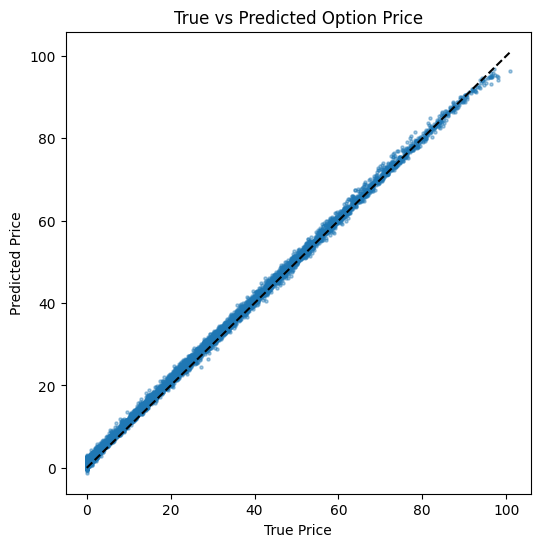

In [16]:
plt.figure(figsize=(6,6))
plt.scatter(df_err['true_price'], df_err['pred_price'], s=5, alpha=0.4)
maxv = max(df_err['true_price'].max(), df_err['pred_price'].max())
plt.plot([0, maxv],[0, maxv], 'k--')
plt.xlabel("True Price")
plt.ylabel("Predicted Price")
plt.title("True vs Predicted Option Price")
plt.show()


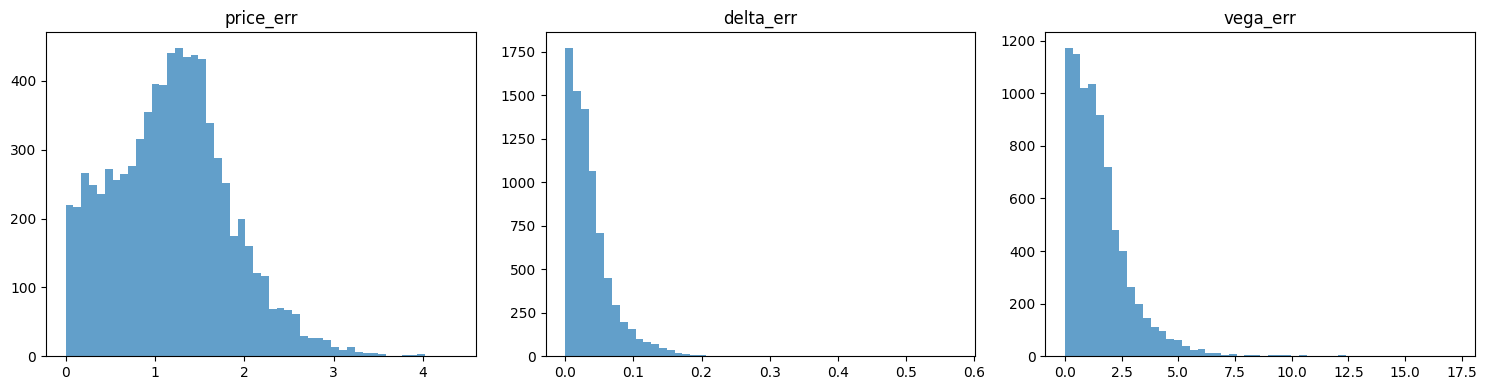

In [17]:
fig, axes = plt.subplots(1,3, figsize=(15,4))
for ax, col in zip(axes, ['price_err','delta_err','vega_err']):
    ax.hist(df_err[col], bins=50, alpha=0.7)
    ax.set_title(col)
plt.tight_layout()
plt.show()


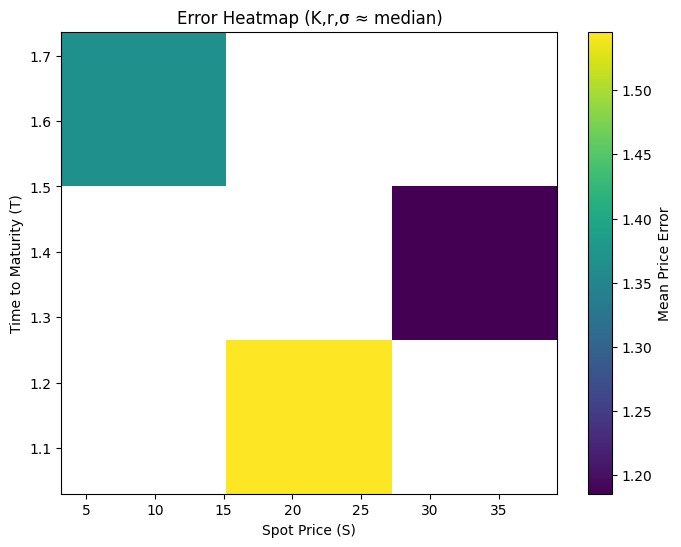

In [18]:
# pick a slice: fix K, r, sigma at their medians
mask = (
    (np.isclose(df_val['K'], df_val['K'].median(), atol=1.0)) &
    (np.isclose(df_val['r'], df_val['r'].median(), atol=0.005)) &
    (np.isclose(df_val['sigma'], df_val['sigma'].median(), atol=0.02))
)
slice_df = df_err[mask]

pivot = slice_df.pivot_table(
    index='T', columns='true_price', values='price_err', aggfunc='mean'
)

plt.figure(figsize=(8,6))
plt.imshow(pivot, origin='lower', aspect='auto',
           extent=[pivot.columns.min(), pivot.columns.max(),
                   pivot.index.min(), pivot.index.max()])
plt.colorbar(label="Mean Price Error")
plt.xlabel("Spot Price (S)")
plt.ylabel("Time to Maturity (T)")
plt.title("Error Heatmap (K,r,σ ≈ median)")
plt.show()


In [19]:
rmse_price = np.sqrt((df_err['price_err']**2).mean())
rmse_delta = np.sqrt((df_err['delta_err']**2).mean())
rmse_vega  = np.sqrt((df_err['vega_err']**2).mean())

print(f"Validation RMSEs → Price: {rmse_price:.4f}, Delta: {rmse_delta:.4f}, Vega: {rmse_vega:.4f}")


Validation RMSEs → Price: 1.3631, Delta: 0.0524, Vega: 2.0608
